custom Polynomial SVM:
Accuracy: 0.40
sklearn Polynomial SVM:
Accuracy: 0.70


C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\mlxtend\plotting\decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


Text(0.5, 1.0, 'Polynomial SVM')

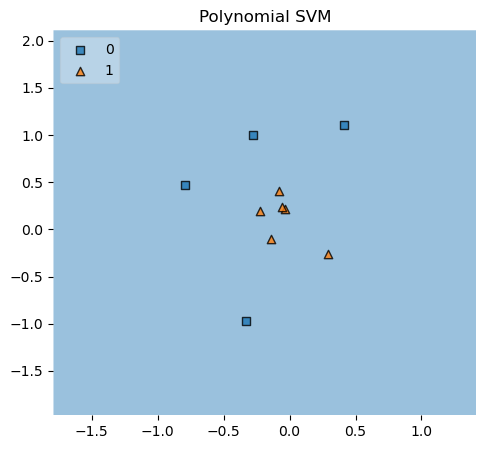

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions

class SVM():
    def __init__(self, kernel='linear', degree=3, C=1.0, tol=1e-3, max_iter=1000):
        self.kernel = kernel
        self.degree = degree
        self.C = C
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.X = X
        self.y = y

        # Initialize alpha and bias
        self.alpha = np.zeros(n_samples)
        self.b = 0

        # Training loop
        num_changed_alphas = 0
        examine_all = True

        for _ in range(self.max_iter):
            num_changed_alphas = 0

            if examine_all:
                for i in range(n_samples):
                    num_changed_alphas += self.examine(i)
            else:
                non_bound_indices = np.where((self.alpha > 0) & (self.alpha < self.C))[0]
                for i in non_bound_indices:
                    num_changed_alphas += self.examine(i)

            if examine_all:
                examine_all = False
            elif num_changed_alphas == 0:
                examine_all = True

        # Compute the bias
        self.b = self._compute_bias()

    def _kernel_function(self, x1, x2):
        if self.kernel == 'linear':
            return np.dot(x1, x2)
        elif self.kernel == 'poly':
            return (np.dot(x1, x2) + 1) ** self.degree
        else:
            raise ValueError("Unsupported kernel type")

    def examine(self, i2):
        y2 = self.y[i2]
        alpha2 = self.alpha[i2]
        x2 = self.X[i2]
        E2 = self.decision_function(x2) - y2

        
        if (y2 * E2 < -self.tol and alpha2 < self.C) or (y2 * E2 > self.tol and alpha2 > 0):
            
            if E2 > 0:
                i1 = np.argmin(self.alpha)
            else:
                i1 = np.argmax(self.alpha)

            if self.smo_step(i1, i2):
                return 1

        return 0

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        alpha1 = self.alpha[i1]
        alpha2 = self.alpha[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        x1 = self.X[i1]
        x2 = self.X[i2]

        E1 = self.decision_function(x1) - y1
        E2 = self.decision_function(x2) - y2

        # Compute L and H, the bounds on alpha2
        if y1 != y2:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        else:
            L = max(0, alpha1 + alpha2 - self.C)
            H = min(self.C, alpha1 + alpha2)

        if L == H:
            return 0

        k11 = self._kernel_function(x1, x1)
        k22 = self._kernel_function(x2, x2)
        k12 = self._kernel_function(x1, x2)

        eta = 2 * k12 - k11 - k22

        if eta < 0:
            
            alpha2_new = alpha2 - y2 * (E1 - E2) / eta
            alpha2_new = max(L, min(H, alpha2_new))

            if abs(alpha2_new - alpha2) < 1e-5:
                return 0

         
            alpha1_new = alpha1 + y1 * y2 * (alpha2 - alpha2_new)

    
            b1 = self.b - E1 - y1 * (alpha1_new - alpha1) * k11 - y2 * (alpha2_new - alpha2) * k12
            b2 = self.b - E2 - y1 * (alpha1_new - alpha1) * k12 - y2 * (alpha2_new - alpha2) * k22

            if 0 < alpha1_new < self.C:
                self.b = b1
            elif 0 < alpha2_new < self.C:
                self.b = b2
            else:
                self.b = (b1 + b2) / 2

       
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new

            return 1

        return 0

    def decision_function(self, X):
        if len(X.shape) == 1:
            return np.sum(self.alpha * self.y * np.array([self._kernel_function(X, xi) for xi in self.X])) - self.b
        else:
            return np.sum(np.array([self.alpha * self.y * np.array([self._kernel_function(xi, xj) for xi in self.X]) for xj in X]) - self.b, axis=1)


    def _compute_bias(self):
       
        support_vector_indices = np.where((self.alpha > 0) & (self.alpha < self.C))[0]
        

        if len(support_vector_indices) > 0:
            i = support_vector_indices[0]
            return self.y[i] - np.sum(self.alpha * self.y * np.array([self._kernel_function(self.X[i], xi) for xi in self.X])) + self.b
        else:
            return 0

    def predict(self, X):
        if isinstance(X, np.ndarray):
            return np.sign(self.decision_function(X))
        else:
            return np.sign(self.decision_function(np.array(X)))

        
#make_circles data set
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split


X, y = make_circles(n_samples=100, factor=0.2, noise=0.1, random_state=11)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=11)

custom_svm = SVM(kernel='poly', degree=3, C=1.0, tol=1e-3, max_iter=1000)
custom_svm.fit(X_train, y_train)




accuracy = np.mean(custom_svm.predict(X_test) == y_test)
print("custom Polynomial SVM:")
print(f"Accuracy: {accuracy:.2f}")


sklearn_poly_svm = SVC(kernel='poly', degree=3)
sklearn_poly_svm.fit(X_train, y_train)



def print_accuracy(model, X, y):
    y_pred = model.predict(X)
    accuracy = np.mean(y_pred == y)
    print(f"Accuracy: {accuracy:.2f}")

print("sklearn Polynomial SVM:")
print_accuracy(sklearn_poly_svm, X_test, y_test)



plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_decision_regions(X_test, y_test, clf=custom_svm, legend=2)
plt.title("Polynomial SVM")


